In [771]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import geopy.geocoders
import json # library to handle JASON Files
from geopy.geocoders import Nominatim

import  requests # library to handle requests
from pandas import json_normalize # transform json file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium # map rendering library

print('library imported')

library imported


## Download Zipcode data from we and create data frame

In [772]:
table_TO = pd.read_html('https://www.zipcodestogo.com/North%20Carolina/')

In [773]:
print(f'Total tables: {len(table_TO)}')

Total tables: 4


In [774]:
#Guess that it is the first table
df = table_TO[1]
df.head()

,0,1,2,3
0,Zip Codes for the State of North Carolina,Zip Codes for the State of North Carolina,Zip Codes for the State of North Carolina,Zip Codes for the State of North Carolina
1,Zip Code,City,County,Zip Code Map
2,27006,Advance,Davie,View Map
3,27007,Ararat,Surry,View Map
4,27009,Belews Creek,Forsyth,View Map


In [775]:
#Size Before Cleaning
df.shape

(797, 4)

Cleanup Zipcode Data Frame

In [776]:
df=df.drop([0,1])

In [777]:
df.shape

(795, 4)

In [778]:
df=df.drop(3, axis=1)

In [779]:
df.head()

,0,1,2
2,27006,Advance,Davie
3,27007,Ararat,Surry
4,27009,Belews Creek,Forsyth
5,27011,Boonville,Yadkin
6,27012,Clemmons,Forsyth


In [780]:
df=df.rename(columns={0: 'zip', 1 : 'City', 2 : 'County'})

In [781]:
df2=df.loc[df['County'] == 'Mecklenburg']

In [782]:
#Filter for Charlotte Only
df2=df.loc[df['City'] == 'Charlotte']

In [783]:
df2.head()

,zip,City,County
436,28202,Charlotte,Mecklenburg
437,28203,Charlotte,Mecklenburg
438,28204,Charlotte,Mecklenburg
439,28205,Charlotte,Mecklenburg
440,28206,Charlotte,Mecklenburg


In [784]:
#Drop County
df2 = df2.drop('County', axis=1)

In [785]:
df2.shape

(46, 2)

In [786]:
PCLATLON = pd.read_csv('uszips.csv')

In [787]:
PCLATLON.head()

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18027,-66.75266,Adjuntas,PR,Puerto Rico,True,NaN,17126.0,102.6,72001,Adjuntas,"{""72001"": 98.73, ""72141"": 1.27}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36075,-67.17541,Aguada,PR,Puerto Rico,True,NaN,37895.0,482.5,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.45744,-67.12225,Aguadilla,PR,Puerto Rico,True,NaN,49136.0,552.4,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.16585,-66.93716,Maricao,PR,Puerto Rico,True,NaN,5751.0,50.1,72093,Maricao,"{""72093"": 82.26, ""72153"": 11.68, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29110,-67.12243,Anasco,PR,Puerto Rico,True,NaN,26153.0,272.1,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.81, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico


In [788]:
print(PCLATLON.dtypes)

zip                   int64
lat                 float64
lng                 float64
city                 object
state_id             object
state_name           object
zcta                   bool
parent_zcta         float64
population          float64
density             float64
county_fips           int64
county_name          object
county_weights       object
county_names_all     object
county_fips_all      object
imprecise              bool
military               bool
timezone             object
dtype: object


In [789]:
PCLATLON = PCLATLON.drop(['timezone','military','imprecise','county_fips_all','county_names_all','county_weights','county_name','county_fips','density','population','parent_zcta','zcta','state_id','state_name'], axis='columns')

In [790]:
PCLATLON.head()

,zip,lat,lng,city
0,601,18.18027,-66.75266,Adjuntas
1,602,18.36075,-67.17541,Aguada
2,603,18.45744,-67.12225,Aguadilla
3,606,18.16585,-66.93716,Maricao
4,610,18.29110,-67.12243,Anasco


In [791]:
PCLATLON.dtypes

zip       int64
lat     float64
lng     float64
city     object
dtype: object

In [792]:
PCLATLON['zip'] = PCLATLON['zip'].astype('object')

In [793]:
PCLATLON.dtypes

zip      object
lat     float64
lng     float64
city     object
dtype: object

## Create Merge of Lat and Lng and Zip for Charlotte Area.

In [794]:
zips = pd.merge(df2, PCLATLON[['zip', 'lat', 'lng']], on='zip')

In [795]:
zips.head()

,zip,City,lat,lng


In [796]:
zips = PCLATLON.merge(df2, left_on = 'zip', right_on='zip')

In [797]:
zips.head()

,zip,lat,lng,city,City


In [798]:
zips = pd.merge( PCLATLON, df2, on=['zip'], how= 'outer')

In [799]:
zips = zips.loc[zips['city'] == 'Charlotte']

In [800]:
zips.head()

,zip,lat,lng,city,City
1539,5445,44.30896,-73.23593,Charlotte,NaN
8949,28202,35.22773,-80.84470,Charlotte,NaN
8950,28203,35.20832,-80.85770,Charlotte,NaN
8951,28204,35.21469,-80.82677,Charlotte,NaN
8952,28205,35.22019,-80.78737,Charlotte,NaN


In [801]:
zips.shape

(35, 5)

In [802]:
zips = zips.drop('City', axis=1)

In [803]:
zips.shape

(35, 4)

In [804]:
zips.head(10)

,zip,lat,lng,city
1539,5445,44.30896,-73.23593,Charlotte
8949,28202,35.22773,-80.84470,Charlotte
8950,28203,35.20832,-80.85770,Charlotte
8951,28204,35.21469,-80.82677,Charlotte
8952,28205,35.22019,-80.78737,Charlotte
8953,28206,35.25631,-80.82144,Charlotte
8954,28207,35.19512,-80.82606,Charlotte
8955,28208,35.23153,-80.90611,Charlotte
8956,28209,35.17878,-80.85418,Charlotte
8957,28210,35.12969,-80.85480,Charlotte


In [805]:
print(zips)

         zip       lat       lng       city
1539    5445  44.30896 -73.23593  Charlotte
8949   28202  35.22773 -80.84470  Charlotte
8950   28203  35.20832 -80.85770  Charlotte
8951   28204  35.21469 -80.82677  Charlotte
8952   28205  35.22019 -80.78737  Charlotte
8953   28206  35.25631 -80.82144  Charlotte
8954   28207  35.19512 -80.82606  Charlotte
8955   28208  35.23153 -80.90611  Charlotte
8956   28209  35.17878 -80.85418  Charlotte
8957   28210  35.12969 -80.85480  Charlotte
8958   28211  35.16816 -80.79604  Charlotte
8959   28212  35.18960 -80.74519  Charlotte
8960   28213  35.28459 -80.73339  Charlotte
8961   28214  35.27177 -80.96847  Charlotte
8962   28215  35.24854 -80.69571  Charlotte
8963   28216  35.31039 -80.88830  Charlotte
8964   28217  35.17146 -80.90770  Charlotte
8965   28223  35.30824 -80.73282  Charlotte
8966   28226  35.10767 -80.81837  Charlotte
8967   28227  35.18851 -80.65070  Charlotte
8968   28244  35.22460 -80.84310  Charlotte
8969   28262  35.32609 -80.74234

### Removing Locations that are not from Charlotte

In [806]:
values_to_drop = [5445, 37036, 48813, 52731, 72522, 78011]
condition = zips['zip'].isin(values_to_drop)

zips = zips.drop(zips[condition].index)

zips.head(30)

,zip,lat,lng,city
8949,28202,35.22773,-80.84470,Charlotte
8950,28203,35.20832,-80.85770,Charlotte
8951,28204,35.21469,-80.82677,Charlotte
8952,28205,35.22019,-80.78737,Charlotte
8953,28206,35.25631,-80.82144,Charlotte
8954,28207,35.19512,-80.82606,Charlotte
8955,28208,35.23153,-80.90611,Charlotte
8956,28209,35.17878,-80.85418,Charlotte
8957,28210,35.12969,-80.85480,Charlotte
8958,28211,35.16816,-80.79604,Charlotte


### Because no neighborhood data existed for zip code names, had to create manually from map

In [807]:
zips = pd.read_csv('Out_115.csv')
zips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   zip           29 non-null     int64  
 1   lat           29 non-null     float64
 2   lng           29 non-null     float64
 3   city          29 non-null     object 
 4   neighborhood  29 non-null     object 
dtypes: float64(2), int64(1), object(2)
memory usage: 1.3+ KB


### Lets Get the Geographical Coordinates of Chalotte

In [808]:
address = 'Charlotte, NC'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude
print(lat,lng)

35.2272086 -80.8430827


In [809]:
map_charlotte = folium.Map(location = [lat, lng], zoom_start=10)

for index, row in zips.iterrows():
    lat, lng, neighborhood = row['lat'], row['lng'], row['neighborhood']

    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f'Lat: {lat}, Long: {lng}, {neighborhood}'
    ).add_to(map_charlotte)

map_charlotte

### Define Foursquare Credentials and Version

In [810]:
CLIENT_ID = 'L2EDYABNB0W2ET13EFRUKAALCCUMW5WISTFAMNKQTLUGF5H1'
CLIENT_SECRET = 'F1XHDYW2Z3IW15NGFEI1QQFLTULXFQ0BXVRQWX2EOMEZB5JB'
VERSION = 20232712
radius = 1000
LIMIT = 50

### Exploaring a Single Neighbourhood (Forth Ward)

In [811]:
zips.loc[0,'neighborhood']

'Forth Ward'

In [812]:
#Get the neighborhood's Latitude and Longitude values.
neighborhood_latitude = zips.loc[0, 'lat'] # neighborhood latitude value
neighborhood_longitude = zips.loc[0, 'lng'] # neighborhood longitude value
neighborhood_name = ['Forth Ward'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,
                                                               neighborhood_latitude,
                                                               neighborhood_longitude))

Latitude and longitude values of ['Forth Ward'] are 35.2313622, -80.8396185.


In [813]:
url = "https://api.foursquare.com/v3/places/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighborhood_latitude,
    neighborhood_longitude,
    radius,
    LIMIT
)

headers = {
    "accept": "application/json",
    "Authorization": "fsq3yvDF7jcl5Ch77KhwB5VrXXdKOST7N4dOxes0S+kypXY="
}

response = requests.get(url, headers=headers)

print(response.json())

{'results': [{'fsq_id': '54c996fa498ef5dcb866272c', 'categories': [{'id': 13068, 'name': 'American Restaurant', 'short_name': 'American', 'plural_name': 'American Restaurants', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/default_', 'suffix': '.png'}}, {'id': 13148, 'name': 'French Restaurant', 'short_name': 'French', 'plural_name': 'French Restaurants', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/french_', 'suffix': '.png'}}], 'chains': [], 'closed_bucket': 'VeryLikelyOpen', 'distance': 11, 'geocodes': {'drop_off': {'latitude': 35.231398, 'longitude': -80.839462}, 'main': {'latitude': 35.231589, 'longitude': -80.8396}, 'roof': {'latitude': 35.231589, 'longitude': -80.8396}}, 'link': '/v3/places/54c996fa498ef5dcb866272c', 'location': {'address': '511 N Church St', 'census_block': '371190005031009', 'country': 'US', 'cross_street': '', 'dma': 'Charlotte', 'formatted_address': '511 N Church St, Charlotte, NC 28202', 'locality': 'Charlotte', 'postcod

In [814]:
url = "https://api.foursquare.com/v3/places/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    neighborhood_latitude,
    neighborhood_longitude,
    radius,
    LIMIT
)

headers = {
    "accept": "application/json",
    "Authorization": "fsq3yvDF7jcl5Ch77KhwB5VrXXdKOST7N4dOxes0S+kypXY="
}

response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Extract relevant information from the JSON response
    data = response.json()["results"]

    # Create a DataFrame
    df = pd.DataFrame([
        {
            'name': place['name'],
            'categories': ', '.join(category['name'] for category in place['categories']),
            'latitude': place['geocodes']['main']['latitude'],
            'longitude': place['geocodes']['main']['longitude']
        }
        for place in data
    ])


In [815]:
df.head()

,name,categories,latitude,longitude
0,McNinch House Restaurant,"American Restaurant, French Restaurant",35.231589,-80.839600
1,The Cellar at Duckworth's,"Cocktail Bar, Gastropub, American Restaurant",35.229267,-80.839732
2,McGlohon Theatre,"Music Venue, Theater",35.228964,-80.839756
3,Queen City Grounds,"Café, Coffee Shop, Vegan and Vegetarian Restau...",35.232377,-80.837471
4,Duckworth's Grill & Taphouse Uptown,"Dining and Drinking, Beer Bar, American Restau...",35.229267,-80.839732


## Lets Explore all the Neighbourhood in Charlotte

In [816]:
def getNearbyPlaces(names, latitudes, longitudes, radius=1000):
    places_list = []

    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v3/places/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        headers = {
            "accept": "application/json",
            "Authorization": "fsq3yvDF7jcl5Ch77KhwB5VrXXdKOST7N4dOxes0S+kypXY="
        }

        # make the GET request
        response = requests.get(url, headers=headers)

        # check if the request was successful
        if response.status_code == 200:
            results = response.json()["results"]

            # return only relevant information for each nearby place
            places_list.append([(
                name,
                lat,
                lng,
                place['name'],
                place['geocodes']['main']['latitude'],
                place['geocodes']['main']['longitude'],
                ', '.join(category['name'] for category in place['categories'])
            ) for place in results])
        else:
            print(f"Error for {name}: {response.status_code}")

    nearby_places = pd.DataFrame([item for place_list in places_list for item in place_list])
    nearby_places.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Place',
                             'Place Latitude',
                             'Place Longitude',
                             'Place Categories']

    return nearby_places

In [817]:
# Call the function
nearby_places = getNearbyPlaces(names=zips['neighborhood'], latitudes=zips['lat'], longitudes=zips['lng'])

Forth Ward
Dilworth
Elizabeth
Draper Ave
Tryon Hills
Myers Park
Ashley Park
Ashbrook
Beverly Woods
Providence Park
Idlewild
Newell
Arlington
Silverwood
Oakdale
Yorkmount
University City South
Carmel
Mint Hill
Second Ward
University City North
West Sugar Creek
Matthews
Ayrsley
Myers Park
Providence Crossing
Steele Creek
First Ward
Third Ward


In [818]:
# Display the dataframe shape
nearby_places.shape

(606, 7)

In [819]:
nearby_places.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Place,Place Latitude,Place Longitude,Place Categories
0,Forth Ward,35.231362,-80.839619,McNinch House Restaurant,35.231589,-80.839600,"American Restaurant, French Restaurant"
1,Forth Ward,35.231362,-80.839619,The Cellar at Duckworth's,35.229267,-80.839732,"Cocktail Bar, Gastropub, American Restaurant"
2,Forth Ward,35.231362,-80.839619,McGlohon Theatre,35.228964,-80.839756,"Music Venue, Theater"
3,Forth Ward,35.231362,-80.839619,Queen City Grounds,35.232377,-80.837471,"Café, Coffee Shop, Vegan and Vegetarian Restau..."
4,Forth Ward,35.231362,-80.839619,Duckworth's Grill & Taphouse Uptown,35.229267,-80.839732,"Dining and Drinking, Beer Bar, American Restau..."


In [820]:
nearby_places.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Place,Place Latitude,Place Longitude,Place Categories
Neighborhood,,,,,,
Arlington,15,15,15,15,15,15
Ashbrook,30,30,30,30,30,30
Ashley Park,17,17,17,17,17,17
Ayrsley,30,30,30,30,30,30
Beverly Woods,10,10,10,10,10,10
Carmel,4,4,4,4,4,4
Dilworth,50,50,50,50,50,50
Draper Ave,20,20,20,20,20,20
Elizabeth,49,49,49,49,49,49


In [821]:
#Unique Values
print('There are {} unique categories'.format(len(nearby_places['Place Categories'].unique())))

There are 274 unique categories


In [822]:
# one hot encoding
charlotte_onehot= pd.get_dummies(nearby_places[['Place Categories']],prefix="",prefix_sep="")

# add neighborhood column back to dataframe
charlotte_onehot['Neighborhood'] = nearby_places['Neighborhood']

# move Neighborhood column to the first column
fixed_col=[charlotte_onehot.columns[-1]] + list(charlotte_onehot.columns[:-1])
charlotte_onehot = charlotte_onehot[fixed_col]

charlotte_onehot.head()

,Neighborhood,,Acupuncture Clinic,Addiction Treatment Center,Ambulance Service,American Restaurant,"American Restaurant, Cajun and Creole Restaurant","American Restaurant, Chinese Restaurant, Seafood Restaurant","American Restaurant, Fast Food Restaurant","American Restaurant, Fast Food Restaurant, Greek Restaurant","American Restaurant, Fast Food Restaurant, Salad Restaurant","American Restaurant, French Restaurant","American Restaurant, Greek Restaurant, Sandwich Spot","American Restaurant, Italian Restaurant, Noodle Restaurant","American Restaurant, South American Restaurant, Southern Food Restaurant","American Restaurant, Steakhouse","American Restaurant, Taco Restaurant","American Restaurant, Tex-Mex Restaurant",Antique Store,"Arcade, Cocktail Bar, Restaurant",Art Gallery,Art Museum,Arts and Crafts Store,Arts and Entertainment,"Arts and Entertainment, Bar","Assisted Living Service, Nursing Home","BBQ Joint, American Restaurant","BBQ Joint, Deli, New American Restaurant","BBQ Joint, Japanese Restaurant",Bagel Shop,"Bagel Shop, Coffee Shop, Sandwich Spot","Bakery, Café, Dining and Drinking","Bakery, Café, Sandwich Spot","Bakery, Cupcake Shop, Restaurant","Bakery, French Restaurant","Bakery, Ice Cream Parlor, Restaurant","Bar, American Restaurant, South American Restaurant","Bar, Brewery, Restaurant","Bar, Deli","Bar, Italian Restaurant, New American Restaurant",Baseball Field,Basketball Court,"Bathroom Contractor, Carpet and Flooring Contractor, Kitchen Remodeler","Beer Bar, Brewery","Beer Garden, Pub",Bicycle Store,Big Box Store,"Big Box Store, Grocery Store","Body Piercing Shop, Martial Arts Dojo",Bookstore,"Bookstore, Comic Book Store",Botanical Garden,Brasserie,"Brazilian Restaurant, Steakhouse",Brewery,"Brewery, Restaurant","Buffet, Chinese Restaurant, Sushi Restaurant",Burger Joint,"Burger Joint, American Restaurant","Burger Joint, American Restaurant, Fast Food Restaurant","Burger Joint, Fast Food Restaurant, Sandwich Spot","Burger Joint, Fish and Chips Shop, American Restaurant",Burrito Restaurant,Business and Professional Services,"Cafe, Coffee, and Tea House, Ice Cream Parlor, Restaurant","Cafeteria, Physician","Café, American Restaurant","Café, American Restaurant, Southern Food Restaurant","Café, Coffee Shop, American Restaurant","Café, Coffee Shop, Vegan and Vegetarian Restaurant",Car Parts and Accessories,Caribbean Restaurant,Cemetery,Charity,Chinese Restaurant,"Chinese Restaurant, Sushi Restaurant",Chiropractor,Church,"Clothing Store, Shoe Store","Cocktail Bar, American Restaurant","Cocktail Bar, American Restaurant, Seafood Restaurant","Cocktail Bar, Gastropub, American Restaurant","Cocktail Bar, Hotel Bar, Restaurant","Cocktail Bar, Pizzeria, New American Restaurant","Cocktail Bar, Pub, Restaurant",Coffee Shop,"Coffee Shop, Deli, Sandwich Spot","Coffee Shop, Restaurant",Comedy Club,"Concert Hall, Music Venue, Theater","Concert Hall, Rock Club, Theater",Construction,Construction Supplies Store,"Construction, Landscaper and Gardener, Tree Service",Convenience Store,Cosmetics Store,Daycare,Deli,"Deli, American Restaurant, Sandwich Spot","Deli, American Restaurant, Wings Joint","Deli, Fast Food Restaurant",Dentist,"Dentist, Oral Surgeon",Department Store,Dermatologist,Dessert Shop,"Dining and Drinking, Beer Bar, American Restaurant",Disc Golf Course,Discount Store,Doctor's Office,Dog Park,"Dog Park, Urban Park",Donut Shop,"Doors and Windows Contractor, General Contractor",Drugstore,Dumpling Restaurant,"Electrician, General Contractor",Electronics Store,Elementary School,Emergency Room,"Event Service, Event Space",Family Medicine Doctor,Farm,Fast Food Restaurant,"Fast Food Restaurant, Burrito Restaurant, Tex-Mex Restaurant","Fast Food Restaurant, Mexican Restaurant",Fire Station,"Fish Market, Grocery Store, Meat and Seafood Store",Flower Store,"French Restaurant, Italian Restaurant, New American Restaurant","French Restaurant, New American Restaurant, Seafood Restaurant","Fried Chicken Joint, Fast Food Restauran

In [823]:
charlotte_onehot.shape

(606, 275)

In [824]:
# group rows by neighborhood and by taking the mean of the frequency of occurence of each category
charlotte_grouped = charlotte_onehot.groupby('Neighborhood').mean().reset_index()
charlotte_grouped.head()

,Neighborhood,,Acupuncture Clinic,Addiction Treatment Center,Ambulance Service,American Restaurant,"American Restaurant, Cajun and Creole Restaurant","American Restaurant, Chinese Restaurant, Seafood Restaurant","American Restaurant, Fast Food Restaurant","American Restaurant, Fast Food Restaurant, Greek Restaurant","American Restaurant, Fast Food Restaurant, Salad Restaurant","American Restaurant, French Restaurant","American Restaurant, Greek Restaurant, Sandwich Spot","American Restaurant, Italian Restaurant, Noodle Restaurant","American Restaurant, South American Restaurant, Southern Food Restaurant","American Restaurant, Steakhouse","American Restaurant, Taco Restaurant","American Restaurant, Tex-Mex Restaurant",Antique Store,"Arcade, Cocktail Bar, Restaurant",Art Gallery,Art Museum,Arts and Crafts Store,Arts and Entertainment,"Arts and Entertainment, Bar","Assisted Living Service, Nursing Home","BBQ Joint, American Restaurant","BBQ Joint, Deli, New American Restaurant","BBQ Joint, Japanese Restaurant",Bagel Shop,"Bagel Shop, Coffee Shop, Sandwich Spot","Bakery, Café, Dining and Drinking","Bakery, Café, Sandwich Spot","Bakery, Cupcake Shop, Restaurant","Bakery, French Restaurant","Bakery, Ice Cream Parlor, Restaurant","Bar, American Restaurant, South American Restaurant","Bar, Brewery, Restaurant","Bar, Deli","Bar, Italian Restaurant, New American Restaurant",Baseball Field,Basketball Court,"Bathroom Contractor, Carpet and Flooring Contractor, Kitchen Remodeler","Beer Bar, Brewery","Beer Garden, Pub",Bicycle Store,Big Box Store,"Big Box Store, Grocery Store","Body Piercing Shop, Martial Arts Dojo",Bookstore,"Bookstore, Comic Book Store",Botanical Garden,Brasserie,"Brazilian Restaurant, Steakhouse",Brewery,"Brewery, Restaurant","Buffet, Chinese Restaurant, Sushi Restaurant",Burger Joint,"Burger Joint, American Restaurant","Burger Joint, American Restaurant, Fast Food Restaurant","Burger Joint, Fast Food Restaurant, Sandwich Spot","Burger Joint, Fish and Chips Shop, American Restaurant",Burrito Restaurant,Business and Professional Services,"Cafe, Coffee, and Tea House, Ice Cream Parlor, Restaurant","Cafeteria, Physician","Café, American Restaurant","Café, American Restaurant, Southern Food Restaurant","Café, Coffee Shop, American Restaurant","Café, Coffee Shop, Vegan and Vegetarian Restaurant",Car Parts and Accessories,Caribbean Restaurant,Cemetery,Charity,Chinese Restaurant,"Chinese Restaurant, Sushi Restaurant",Chiropractor,Church,"Clothing Store, Shoe Store","Cocktail Bar, American Restaurant","Cocktail Bar, American Restaurant, Seafood Restaurant","Cocktail Bar, Gastropub, American Restaurant","Cocktail Bar, Hotel Bar, Restaurant","Cocktail Bar, Pizzeria, New American Restaurant","Cocktail Bar, Pub, Restaurant",Coffee Shop,"Coffee Shop, Deli, Sandwich Spot","Coffee Shop, Restaurant",Comedy Club,"Concert Hall, Music Venue, Theater","Concert Hall, Rock Club, Theater",Construction,Construction Supplies Store,"Construction, Landscaper and Gardener, Tree Service",Convenience Store,Cosmetics Store,Daycare,Deli,"Deli, American Restaurant, Sandwich Spot","Deli, American Restaurant, Wings Joint","Deli, Fast Food Restaurant",Dentist,"Dentist, Oral Surgeon",Department Store,Dermatologist,Dessert Shop,"Dining and Drinking, Beer Bar, American Restaurant",Disc Golf Course,Discount Store,Doctor's Office,Dog Park,"Dog Park, Urban Park",Donut Shop,"Doors and Windows Contractor, General Contractor",Drugstore,Dumpling Restaurant,"Electrician, General Contractor",Electronics Store,Elementary School,Emergency Room,"Event Service, Event Space",Family Medicine Doctor,Farm,Fast Food Restaurant,"Fast Food Restaurant, Burrito Restaurant, Tex-Mex Restaurant","Fast Food Restaurant, Mexican Restaurant",Fire Station,"Fish Market, Grocery Store, Meat and Seafood Store",Flower Store,"French Restaurant, Italian Restaurant, New American Restaurant","French Restaurant, New American Restaurant, Seafood Restaurant","Fried Chicken Joint, Fast Food Restauran

In [825]:
charlotte_grouped.shape

(28, 275)

In [826]:
# print each neighborhood along with the top 5 most common categories
num_top_venues = 5

for hood in charlotte_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = charlotte_grouped[charlotte_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arlington----
                venue  freq
0              Church  0.27
1  Chinese Restaurant  0.07
2         Sports Club  0.07
3   Convenience Store  0.07
4           Drugstore  0.07


----Ashbrook----
                              venue  freq
0                            Church  0.07
1                           Charity  0.03
2                     Swimming Pool  0.03
3  Bakery, Cupcake Shop, Restaurant  0.03
4         Bakery, French Restaurant  0.03


----Ashley Park----
                       venue  freq
0                     Church  0.24
1          Convenience Store  0.12
2              Antique Store  0.06
3          Ambulance Service  0.06
4  Car Parts and Accessories  0.06


----Ayrsley----
                    venue  freq
0          Discount Store  0.10
1            Veterinarian  0.07
2           Grocery Store  0.03
3       Convenience Store  0.03
4  Family Medicine Doctor  0.03


----Beverly Woods----
               venue  freq
0             Church   0.3
1               Park   

In [827]:
### Let’s put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [828]:
# now create the new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = charlotte_grouped['Neighborhood']

for ind in np.arange(charlotte_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(charlotte_grouped.iloc[ind, 1:], num_top_venues)
    
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington,Church,Discount Store,"Dentist, Oral Surgeon",Sports Club,Convenience Store,Drugstore,Farm,"Deli, Fast Food Restaurant",Car Parts and Accessories,Chinese Restaurant
1,Ashbrook,Church,Shopping Mall,Art Gallery,Swimming Pool,"New American Restaurant, Southern Food Restaur...","New American Restaurant, Seafood Restaurant","Karaoke Bar, Dive Bar","Deli, Fast Food Restaurant","Bakery, Cupcake Shop, Restaurant","Bakery, French Restaurant"
2,Ashley Park,Church,Convenience Store,Antique Store,Restaurant,Ambulance Service,"Electrician, General Contractor",Car Parts and Accessories,High School,"Doors and Windows Contractor, General Contractor","General Contractor, Kitchen Remodeler"
3,Ayrsley,Discount Store,Veterinarian,"Burger Joint, American Restaurant, Fast Food R...","Construction, Landscaper and Gardener, Tree Se...",Manufacturer,Jewelry Store,Mexican Restaurant,"Italian Restaurant, Pizzeria","Manufacturer, Drugstore, Medical Supply Store",Industrial Equipment Supplier
4,Beverly Woods,Church,Park,Swimming Pool,Elementary School,Playground,Nursing Home,Construction,Medical Supply Store,Mediterranean Restaurant,Medical Center
5,Carmel,Bagel Shop,Golf Course,"Italian Restaurant, Pizzeria","Sports Bar, Burger Joint, American Restaurant",Acupuncture Clinic,Miscellaneous Store,Middle School,"Mexican Restaurant, Bar",Mexican Restaurant,Metals Supplier
6,Dilworth,"Wine Bar, Tapas Restaurant",Church,"Coffee Shop, Restaurant",Burger Joint,"Burger Joint, American Restaurant, Fast Food R...","Cafe, Coffee, and Tea House, Ice Cream Parlor,...","Café, Coffee Shop, American Restaurant","Brewery, Restaurant","Cocktail Bar, Pizzeria, New American Restaurant","Beer Bar, Brewery"
7,Draper Ave,Church,Pizzeria,Mexican Restaurant,Convenience Store,Discount Store,"Fish Market, Grocery Store, Meat and Seafood S...","Deli, American Restaurant, Wings Joint","Pizzeria, Italian Restaurant","Mediterranean Restaurant, Middle Eastern Resta...",Fast Food Restaurant
8,Elizabeth,Park,Pet Supplies Store,Gift Store,Bicycle Store,"Deli, American Restaurant, Sandwich Spot","Concert Hall, Rock Club, Theater","Coffee Shop, Restaurant",Coffee Shop,Physical Therapy Clinic,Pizzeria
9,First Ward,Arts and Entertainment,Park,"Music Venue, Theater","Beer Garden, Pub","Bar, Italian Restaurant, New American Restaurant",Stadium,Sports and Recreation,"Café, Coffee Shop, Vegan and Vegetarian Restau...",Landmarks and Outdoors,Souvenir Store


## Cluster the Neighborhoods

In [829]:
# Run k-means to cluster the neighborhood into 4 clusters.
kclusters = 7 # set number of clusters

charlotte_grouped_clustering = charlotte_grouped.drop('Neighborhood',axis=1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, verbose=1, algorithm='lloyd', max_iter=100).fit(charlotte_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

Initialization complete


C:\Users\shrey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\shrey\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Iteration 0, inertia 2.27026691313457.
Iteration 1, inertia 1.4728662946652045.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.272175013604956.
Iteration 1, inertia 1.5680045515502443.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.0823513127673676.
Iteration 1, inertia 1.5264586555274966.
Iteration 2, inertia 1.4808580325866636.
Iteration 3, inertia 1.4620728718814737.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 2.065082604053936.
Iteration 1, inertia 1.4042233412493117.
Iteration 2, inertia 1.3744179242654921.
Converged at iteration 2: strict convergence.
Initialization complete
Iteration 0, inertia 2.399472906054703.
Iteration 1, inertia 1.6130377236220703.
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 2.106661032571172.
Iteration 1, inertia 1.4764387947239228.
Converged at iteration 1: strict converge

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1])

In [830]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
charlotte_merged = zips

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
charlotte_merged = charlotte_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')

charlotte_merged.head() # check Lost columns

,zip,lat,lng,city,neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,28202,35.231362,-80.839619,Charlotte,Forth Ward,1,Park,Stadium,"Music Venue, Theater","American Restaurant, Steakhouse","Coffee Shop, Restaurant","Pub, Sports Bar, Restaurant","Café, Coffee Shop, Vegan and Vegetarian Restau...","Sports Bar, Brewery, Restaurant","Lounge, New American Restaurant, Spanish Resta...","Lounge, Sports Bar, Restaurant"
1,28203,35.208320,-80.857700,Charlotte,Dilworth,1,"Wine Bar, Tapas Restaurant",Church,"Coffee Shop, Restaurant",Burger Joint,"Burger Joint, American Restaurant, Fast Food R...","Cafe, Coffee, and Tea House, Ice Cream Parlor,...","Café, Coffee Shop, American Restaurant","Brewery, Restaurant","Cocktail Bar, Pizzeria, New American Restaurant","Beer Bar, Brewery"
2,28204,35.214690,-80.826770,Charlotte,Elizabeth,1,Park,Pet Supplies Store,Gift Store,Bicycle Store,"Deli, American Restaurant, Sandwich Spot","Concert Hall, Rock Club, Theater","Coffee Shop, Restaurant",Coffee Shop,Physical Therapy Clinic,Pizzeria
3,28205,35.220190,-80.787370,Charlotte,Draper Ave,0,Church,Pizzeria,Mexican Restaurant,Convenience Store,Discount Store,"Fish Market, Grocery Store, Meat and Seafood S...","Deli, American Restaurant, Wings Joint","Pizzeria, Italian Restaurant","Mediterranean Restaurant, Middle Eastern Resta...",Fast Food Restaurant
4,28206,35.256310,-80.821440,Charlotte,Tryon Hills,1,Trade School,Fire Station,Construction,"Shipping, Freight, and Material Transportation...",Playground,Construction Supplies Store,Hospital,Refrigeration and Ice Supplier,Home Appliance Store,"Bathroom Contractor, Carpet and Flooring Contr..."


In [831]:
charlotte_merged = charlotte_merged.dropna(subset=['Cluster Labels'])

In [832]:
charlotte_merged['Cluster Labels'] = charlotte_merged['Cluster Labels'].astype(np.int64)

In [833]:

# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

marker_colors = []
for lat, lng, poi, cluster in zip(charlotte_merged['lat'], charlotte_merged['lng'], charlotte_merged['neighborhood'], charlotte_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],  # You can use a specific color for testing
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
    
map_clusters


## Examine The Cluster

In [834]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 0, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]


,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,35.22019,0,Church,Pizzeria,Mexican Restaurant,Convenience Store,Discount Store,"Fish Market, Grocery Store, Meat and Seafood S...","Deli, American Restaurant, Wings Joint","Pizzeria, Italian Restaurant","Mediterranean Restaurant, Middle Eastern Resta...",Fast Food Restaurant
6,35.23153,0,Church,Convenience Store,Antique Store,Restaurant,Ambulance Service,"Electrician, General Contractor",Car Parts and Accessories,High School,"Doors and Windows Contractor, General Contractor","General Contractor, Kitchen Remodeler"
8,35.12969,0,Church,Park,Swimming Pool,Elementary School,Playground,Nursing Home,Construction,Medical Supply Store,Mediterranean Restaurant,Medical Center
12,35.27177,0,Church,Discount Store,"Dentist, Oral Surgeon",Sports Club,Convenience Store,Drugstore,Farm,"Deli, Fast Food Restaurant",Car Parts and Accessories,Chinese Restaurant
22,35.10963,0,Church,Housing Development,High School,"Property Management Office, Residential Building",Daycare,Elementary School,Park,Mediterranean Restaurant,"Mediterranean Restaurant, Middle Eastern Resta...",Mental Health Clinic


In [835]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 1, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,35.231362,1,Park,Stadium,"Music Venue, Theater","American Restaurant, Steakhouse","Coffee Shop, Restaurant","Pub, Sports Bar, Restaurant","Café, Coffee Shop, Vegan and Vegetarian Restau...","Sports Bar, Brewery, Restaurant","Lounge, New American Restaurant, Spanish Resta...","Lounge, Sports Bar, Restaurant"
1,35.208320,1,"Wine Bar, Tapas Restaurant",Church,"Coffee Shop, Restaurant",Burger Joint,"Burger Joint, American Restaurant, Fast Food R...","Cafe, Coffee, and Tea House, Ice Cream Parlor,...","Café, Coffee Shop, American Restaurant","Brewery, Restaurant","Cocktail Bar, Pizzeria, New American Restaurant","Beer Bar, Brewery"
2,35.214690,1,Park,Pet Supplies Store,Gift Store,Bicycle Store,"Deli, American Restaurant, Sandwich Spot","Concert Hall, Rock Club, Theater","Coffee Shop, Restaurant",Coffee Shop,Physical Therapy Clinic,Pizzeria
4,35.256310,1,Trade School,Fire Station,Construction,"Shipping, Freight, and Material Transportation...",Playground,Construction Supplies Store,Hospital,Refrigeration and Ice Supplier,Home Appliance Store,"Bathroom Contractor, Carpet and Flooring Contr..."
5,35.195120,1,Elementary School,Grocery Store,Sculpture Garden,Police Station,"Wine Bar, Italian Restaurant",Playground,Video Store,Church,Construction,Chinese Restaurant
7,35.178780,1,Church,Shopping Mall,Art Gallery,Swimming Pool,"New American Restaurant, Southern Food Restaur...","New American Restaurant, Seafood Restaurant","Karaoke Bar, Dive Bar","Deli, Fast Food Restaurant","Bakery, Cupcake Shop, Restaurant","Bakery, French Restaurant"
9,35.168160,1,Church,Pizzeria,Manufacturer,Swimming Pool,Private School,Psychologist,Retail,Martial Arts Dojo,Pediatrician,Doctor's Office
10,35.189600,1,Landmarks and Outdoors,Organization,Office Building,Playground,Church,Elementary School,Mediterranean Restaurant,Medical Supply Store,"Mediterranean Restaurant, Middle Eastern Resta...",Museum
17,35.107670,1,Bagel Shop,Golf Course,"Italian Restaurant, Pizzeria","Sports Bar, Burger Joint, American Restaurant",Acupuncture Clinic,Miscellaneous Store,Middle School,"Mexican Restaurant, Bar",Mexican Restaurant,Metals Supplier
18,35.188510,1,Pest Control Service,Grocery Store,Church,Mental Health Clinic,Video Store,Furniture and Home Store,Drugstore,Playground,Business and Professional Services,"Mexican Restaurant, Bar"


In [836]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 2, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,35.24854,2,Cemetery,"Event Service, Event Space",Mexican Restaurant,Museum,Mover,Miscellaneous Store,Middle School,"Mexican Restaurant, Bar",Metals Supplier,Manufacturer


In [837]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 3, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,35.28459,3,Seafood Restaurant,Mental Health Clinic,Mover,Miscellaneous Store,Middle School,"Mexican Restaurant, Bar",Mexican Restaurant,Metals Supplier,"Mediterranean Restaurant, Middle Eastern Resta...",Pest Control Service


In [838]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 4, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,35.30824,4,Indian Restaurant,Pizzeria,Botanical Garden,"American Restaurant, Fast Food Restaurant","Mexican Restaurant, Bar",Music Store,Museum,Mover,Miscellaneous Store,Middle School


In [839]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 5, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,35.17146,5,Golf Course,Government Building,Government Department,Park,Disc Golf Course,Private School,Tennis Court,Convenience Store,Mexican Restaurant,Miscellaneous Store
26,35.13063,5,Park,Golf Course,Basketball Court,Elementary School,Mental Health Clinic,Miscellaneous Store,Middle School,"Mexican Restaurant, Bar",Mexican Restaurant,Metals Supplier


In [840]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 6, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,35.31039,6,Golf Course,Church,Baseball Field,Metals Supplier,Mover,Miscellaneous Store,Middle School,"Mexican Restaurant, Bar",Mexican Restaurant,"Mediterranean Restaurant, Middle Eastern Resta..."


In [841]:
charlotte_merged.loc[charlotte_merged['Cluster Labels'] == 7, charlotte_merged.columns[[1] + list(range(5, charlotte_merged.shape[1]))]]

,lat,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


 ## Using Decision Tree

In [842]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image
from pydot import graph_from_dot_data


In [843]:
dectree = pd.read_csv('neigh.csv')

In [844]:
dectree.head()

,neighbourhood,cost,food,hotel,bar,business_services,violent_crimes,property_crime,commute
0,Forth Ward,500000,7,8,1,5,20,120,30
1,Dilworth,650000,8,7,0,6,15,100,25
2,Elizabeth,400000,6,6,1,5,18,110,28
3,Draper Ave,300000,5,5,4,4,10,80,20
4,Tryon Hills,450000,7,6,3,5,12,90,22


In [847]:
x = dectree[['cost','food','hotel','bar','business_services','violent_crimes','property_crime','commute']]
y = dectree[['neighbourhood']]

In [848]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   cost               29 non-null     int64
 1   food               29 non-null     int64
 2   hotel              29 non-null     int64
 3   bar                29 non-null     int64
 4   business_services  29 non-null     int64
 5   violent_crimes     29 non-null     int64
 6   property_crime     29 non-null     int64
 7   commute            29 non-null     int64
dtypes: int64(8)
memory usage: 1.9 KB


In [849]:
y = pd.get_dummies(y)

In [850]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [851]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

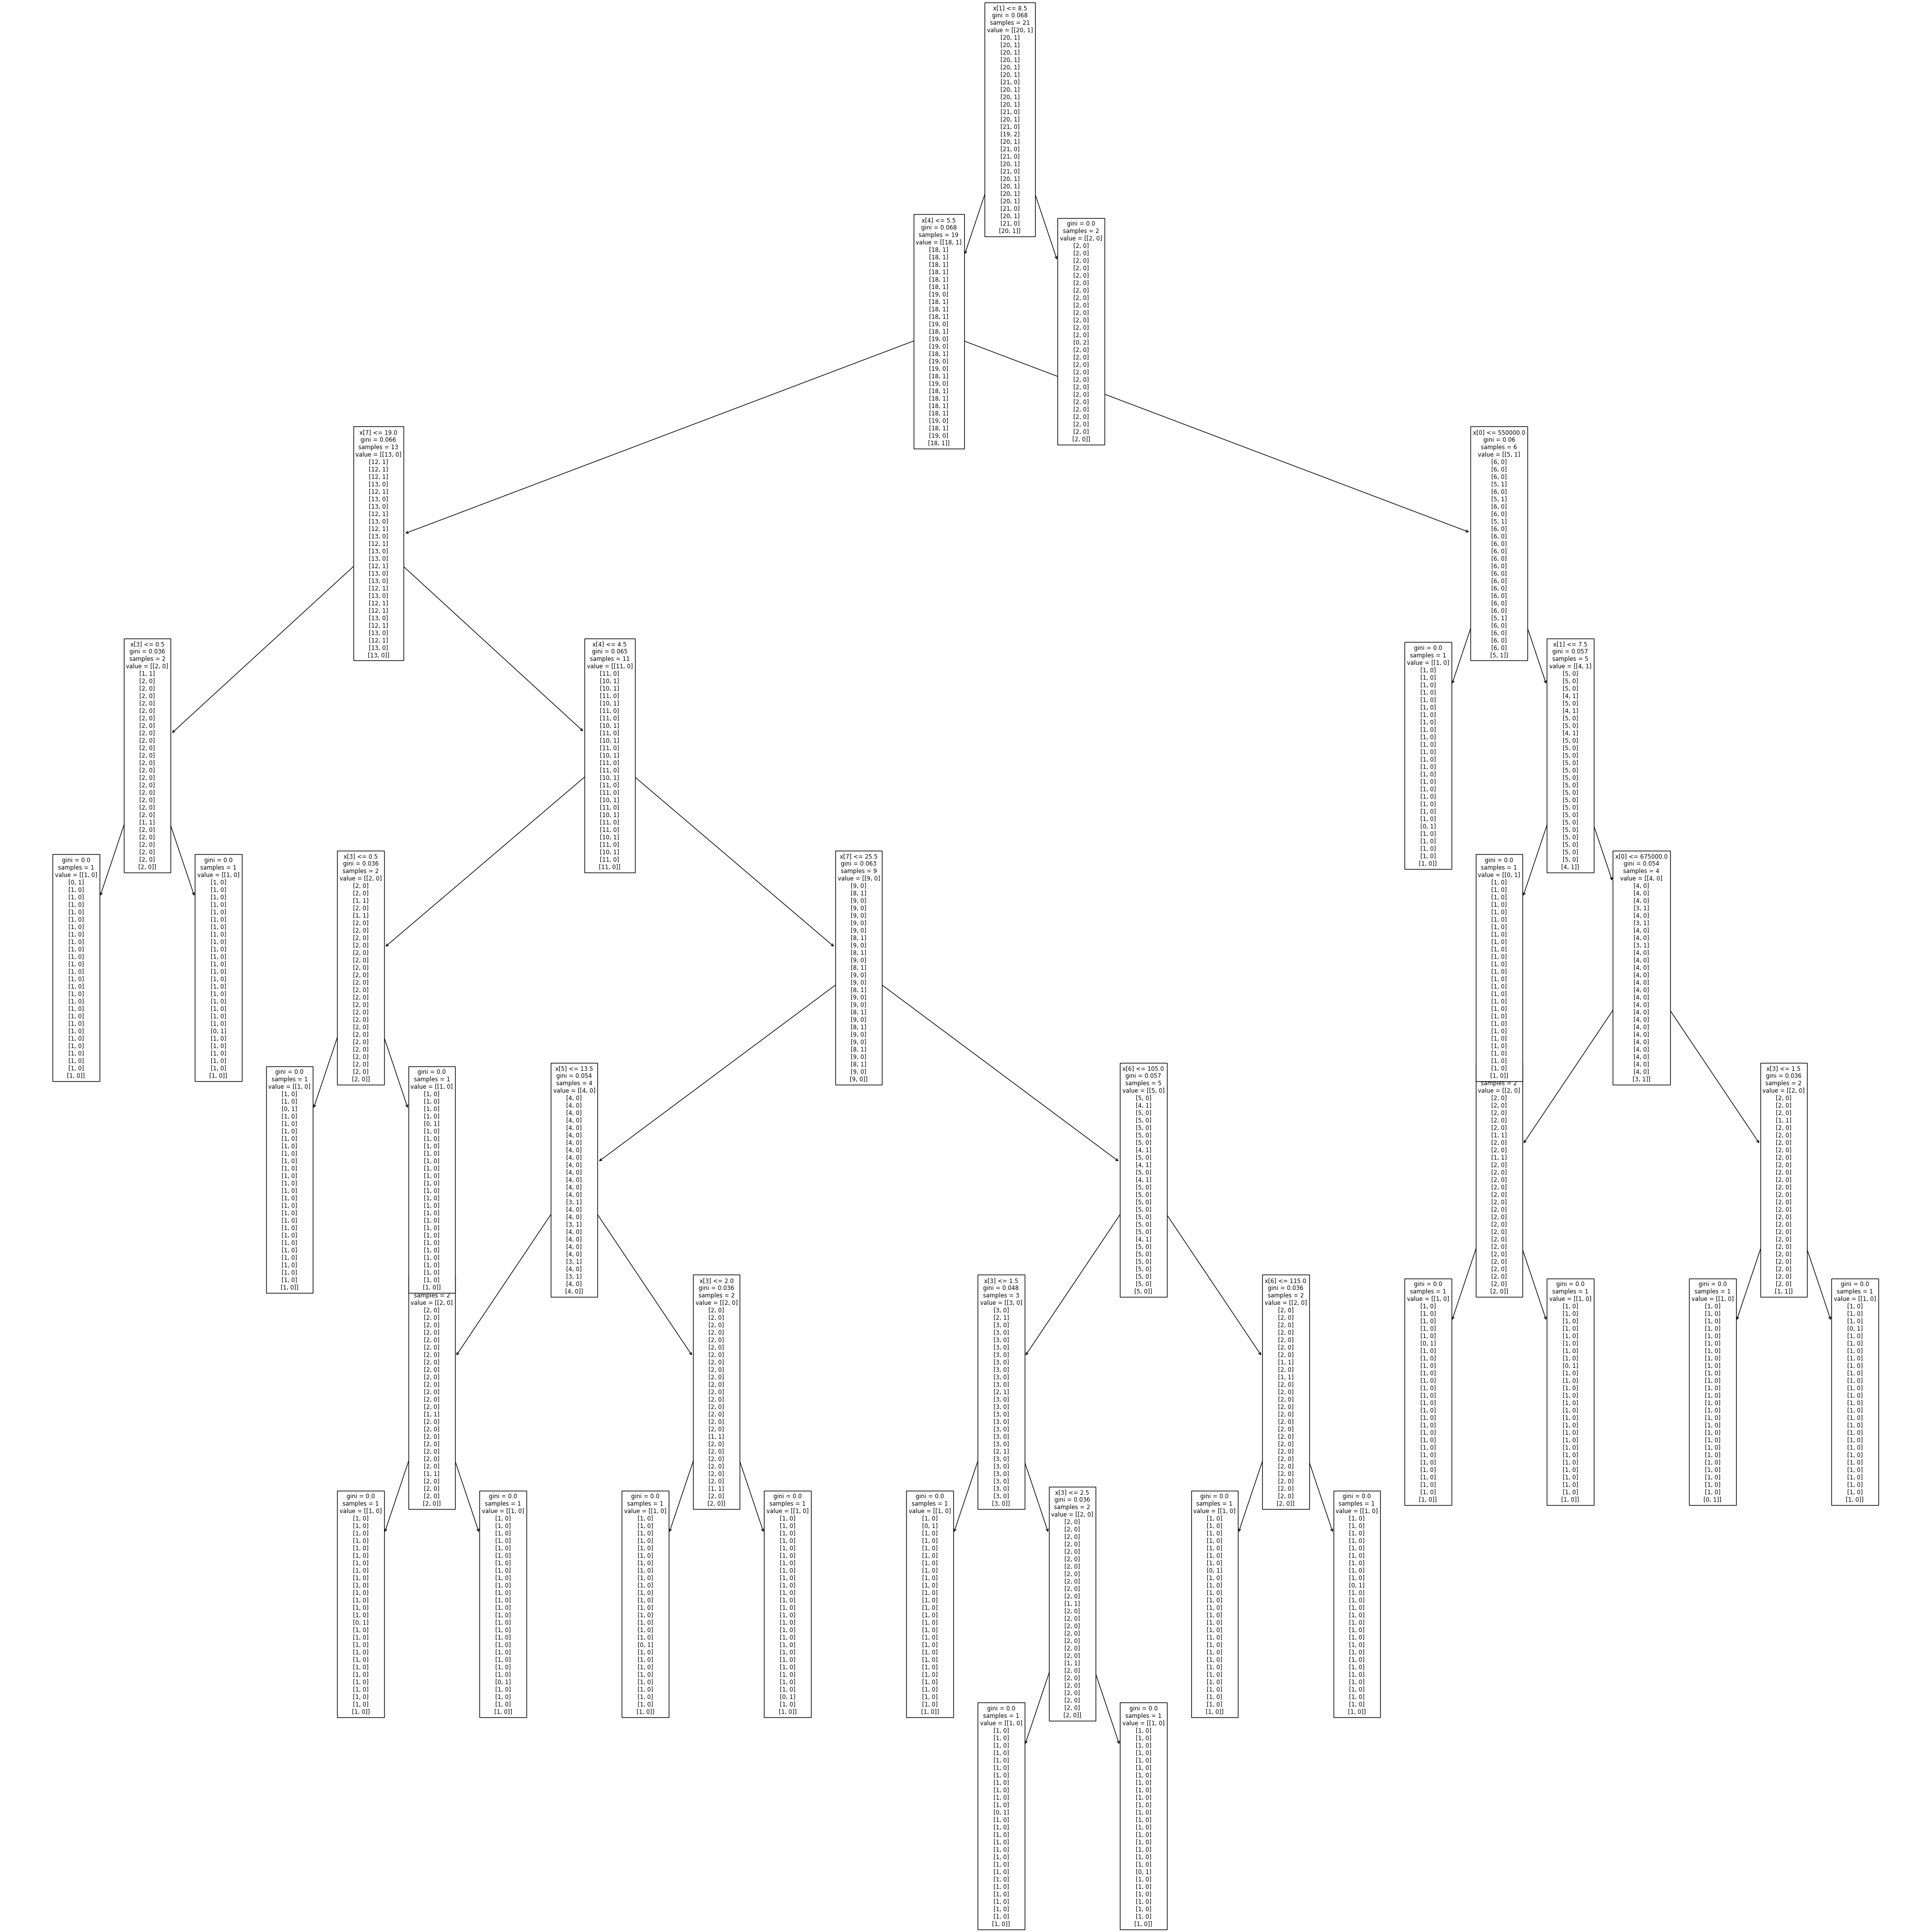

In [852]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,50))
tree.plot_tree(dt)
plt.show()